## ML Final Project

### Cathy Ouyang

In [32]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_gaussian_quantiles
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import tensorflow.compat.v1 as tf
from keras.optimizers import Adam as LegacyAdam
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
import nltk
import ssl
from collections import Counter
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, SimpleRNN, Bidirectional
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Tuple
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau, EarlyStopping
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.datasets import make_classification
from sklearn.calibration import CalibratedClassifierCV

# Bypass SSL certificate verification
#ssl._create_default_https_context = ssl._create_unverified_context
#nltk.download('punkt')
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

In [2]:
df = pd.read_csv('IMDB Dataset.csv') #Importing dataset

In [3]:
df.head() #Looking at first few rows of data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.shape #2 columns and 50,000 reviews

(50000, 2)

In [5]:
print(df.isnull().any(axis=1).sum()) #no missing values

0


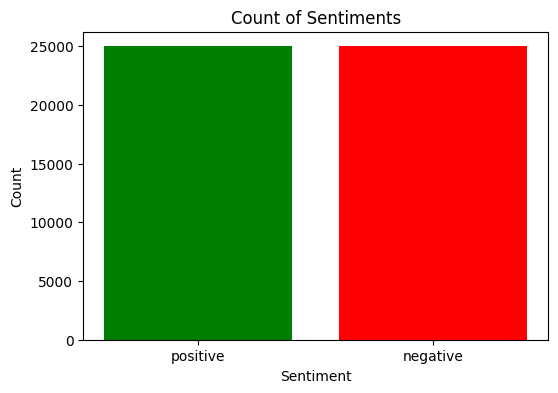

In [6]:
#EDA - count of sentiments, equal distribution of positive and negative reviews

counts = df['sentiment'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(counts.index, counts.values, color=['green', 'red']) 
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Sentiments')
plt.show()

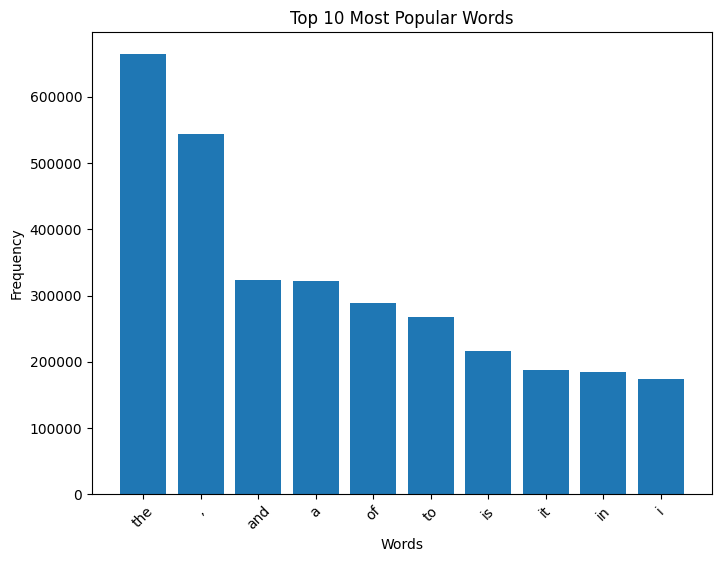

In [7]:
#EDA - most frequent words

all_words = ' '.join(df['review'])
tokenized_words = word_tokenize(all_words.lower())

word_counts = Counter(tokenized_words)

words_to_exclude = ['.', '/', "'", '<', '>', 'br'] 

filtered_word_counts = {word: count for word, count in word_counts.items() if word not in words_to_exclude}

top_words = Counter(filtered_word_counts).most_common(10)  #Chooses top 10 

#Plotting
top_word_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(8, 6))
plt.bar(top_word_df['Word'], top_word_df['Frequency'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Popular Words')
plt.xticks(rotation=45)
plt.show()


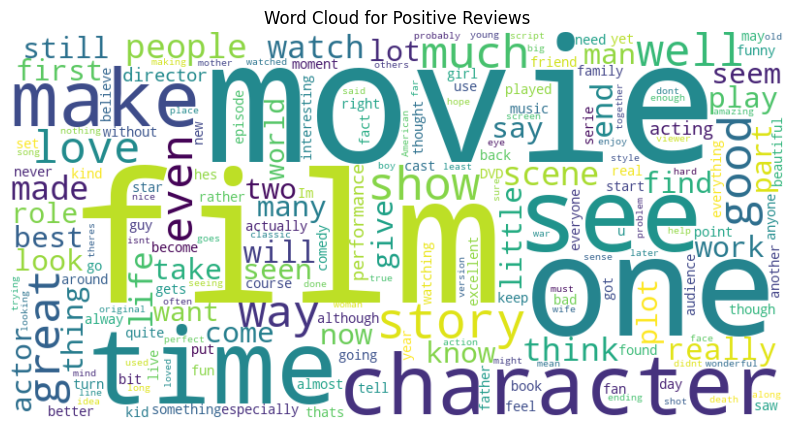

In [8]:
#EDA - positive word cloud

#Concatenate
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['review'])

words_to_exclude = ['.', '/', "'", '<', '>', 'br'] 

for word in words_to_exclude:
    positive_reviews = positive_reviews.replace(word, '')

#generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()


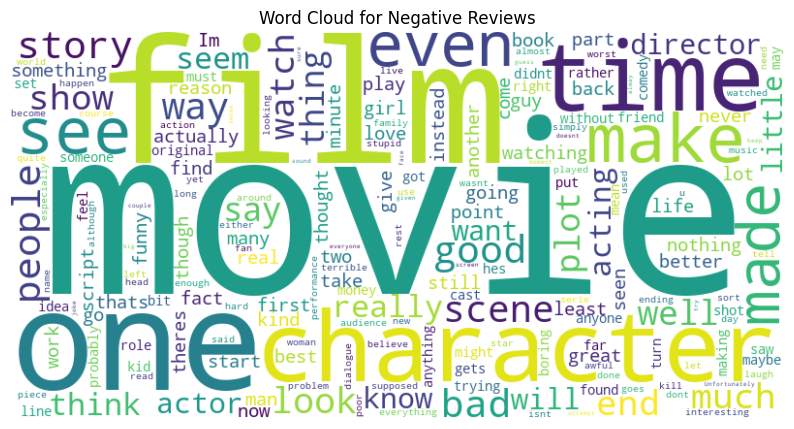

In [9]:
#EDA - negative word cloud

#Concatenate
positive_reviews = ' '.join(df[df['sentiment'] == 'negative']['review'])

words_to_exclude = ['.', '/', "'", '<', '>', 'br']  # Add words you want to exclude here

for word in words_to_exclude:
    positive_reviews = positive_reviews.replace(word, '')

#generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

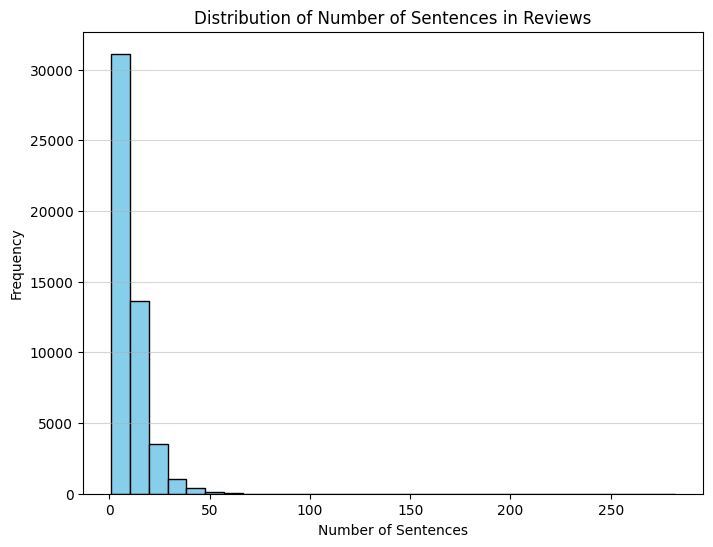

In [10]:
#Function to count sentences
def count_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

df['num_sentences'] = df['review'].apply(count_sentences)

#Plotting
plt.figure(figsize=(8, 6))
plt.hist(df['num_sentences'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Sentences in Reviews')
plt.grid(axis='y', alpha=0.5)
plt.show()

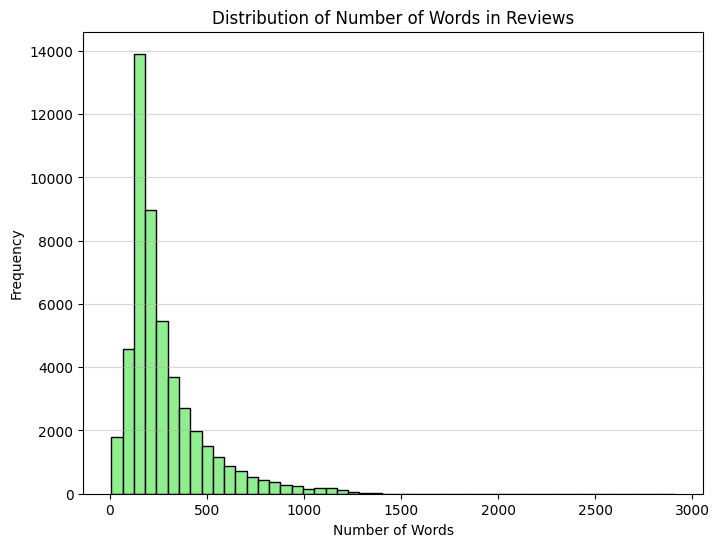

In [11]:
#Function to count words
def count_words(text):
    words = nltk.word_tokenize(text)
    return len(words)

df['num_words'] = df['review'].apply(count_words)

#Plotting
plt.figure(figsize=(8, 6))
plt.hist(df['num_words'], bins=50, color='lightgreen', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Reviews')
plt.grid(axis='y', alpha=0.5)
plt.show()


In [12]:
#Removing some noise since I noticed that there were lots of brackets and slashes in some of the review text
def remove_symbols(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_spec_char(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def nosymbols_text(text):
    text = remove_symbols(text)
    text = remove_spec_char(text)
    text = remove_stopwords(text)
    return text
    
df['review']=df['review'].apply(nosymbols_text)

In [13]:
#Split test and train
review = df["review"]
sentiment = df['sentiment'].map({'negative': 0, 'positive': 1})
X_train, X_test, y_train, y_test = train_test_split(np.array(review), np.array(sentiment), train_size=0.8, random_state=123)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [14]:
X_train.shape

(40000,)

In [15]:
X_test.shape

(10000,)

In [17]:
tokenizer = Tokenizer()
num_words = 1000
max_length = 100

In [18]:
#Tokenization
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

## LSTM

In [20]:
train_sequence = tokenizer.texts_to_sequences(X_train)
train_padd = pad_sequences(train_sequence,maxlen=max_length,truncating='post') #padding to ensure correct shape

In [21]:
test_sequence = tokenizer.texts_to_sequences(X_test)
test_padd = pad_sequences(test_sequence, maxlen=max_length, truncating='post')

In [22]:
embedding_dim = 16
model = Sequential()
model.add(Embedding(num_words,embedding_dim,input_length=max_length))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(6,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
          
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           16000     
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          41472     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 99085 (387.05 KB)
Trainable params: 99085 

In [23]:
callbacks = [
            EarlyStopping(patience = 10, verbose=1),
            ReduceLROnPlateau(factor = 0.5, patience = 3, min_lr = 0.000001, verbose=1),
            ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True,
            verbose=1)

    ] #implementing early stopping

In [24]:
model.compile(optimizer=Adam(0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(train_padd,y_train,epochs=20,validation_data=(test_padd,y_test),callbacks=[callbacks])
loss, accuracy = model.evaluate(test_padd, y_test, batch_size=256)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%') 

Epoch 1/20
1250/1250 [==============================] - ETA: 0s - loss: 0.3941 - accuracy: 0.8202
Epoch 1: val_loss improved from inf to 0.34757, saving model to model.h5
1250/1250 [==============================] - 40s 31ms/step - loss: 0.3941 - accuracy: 0.8202 - val_loss: 0.3476 - val_accuracy: 0.8489 - lr: 0.0010
Epoch 2/20
1249/1250 [============================>.] - ETA: 0s - loss: 0.3306 - accuracy: 0.8575
Epoch 2: val_loss improved from 0.34757 to 0.34163, saving model to model.h5
1250/1250 [==============================] - 39s 31ms/step - loss: 0.3306 - accuracy: 0.8576 - val_loss: 0.3416 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 3/20
1249/1250 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.8648
Epoch 3: val_loss did not improve from 0.34163
1250/1250 [==============================] - 39s 31ms/step - loss: 0.3162 - accuracy: 0.8648 - val_loss: 0.3461 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 4/20
1249/1250 [============================>.] - ETA: 0s -

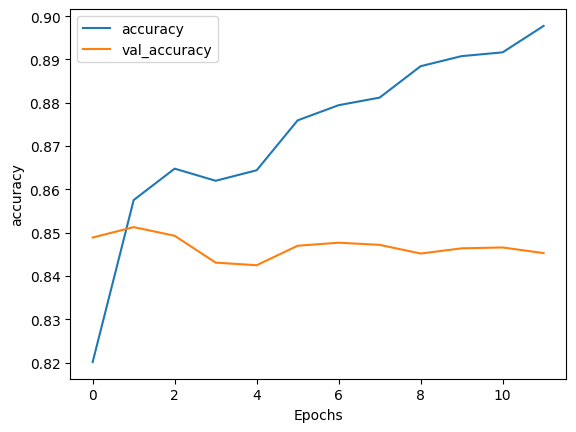

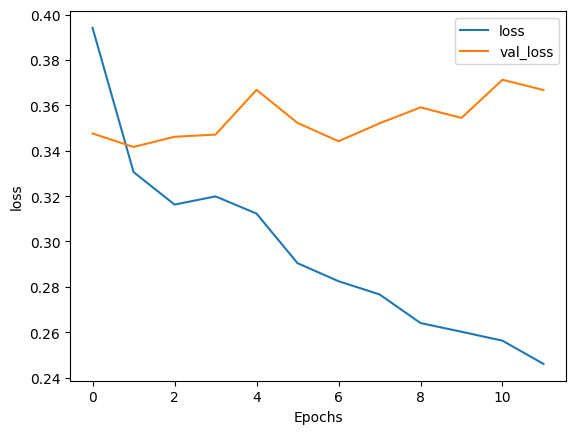

In [25]:
def plot_graphs(history, string):
        plt.plot(history.history[string])
        plt.plot(history.history['val_'+string])
        plt.xlabel("Epochs")
        plt.ylabel(string)
        plt.legend([string, 'val_'+string])
        plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Preparation for Linear SVC

In [34]:
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3)) 
#Only words that appear in at least one document but don't appear in every single document will be included in the vocabulary
cv_train=cv.fit_transform(X_train)
cv_test=cv.transform(X_test)

In [59]:
linear_svc = LinearSVC(C=1.0, random_state=123)
linear_svc.fit(cv_train, y_train)

LinearSVC(random_state=123)

In [60]:
#predictions
y_pred_test_lin = linear_svc.predict(cv_test) 

In [61]:
#accuracy
linear_svc_score=accuracy_score(y_test,y_pred_test_lin)
print("Accuracy :",linear_svc_score)

Accuracy : 0.9001


In [62]:
cm = confusion_matrix(y_test, y_pred_test_lin)
print("Confusion Matrix:")
print(cm)

classification = classification_report(y_test, y_pred_test_lin)
print("\nClassification Report:")
print(classification)

Confusion Matrix:
[[4409  570]
 [ 429 4592]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      4979
         1.0       0.89      0.91      0.90      5021

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

